<a href="https://colab.research.google.com/github/nishantbala/twitter-sentiment-analysis/blob/master/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Classifier**
### Import the libraries, load dataset, print shape of data, data description

In [1]:
!pip install contractions
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import WhitespaceTokenizer           # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt                         # To plot the figures
import seaborn as sns                                   # To plot the figures
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

%matplotlib inline

     |████████████████████████████████| 321 kB 7.4 MB/s 
     |████████████████████████████████| 284 kB 32.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=68898f5689657b8788810ee90a8c6c4b7a99ca5ec7915bc1666f7c93d5627672
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# load dataset
train = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/train.csv?raw=true')
test = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/test.csv?raw=true')

In [3]:
#print shape

train.shape

(31962, 3)

In [4]:
#train data first 5 data
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
#train data description
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


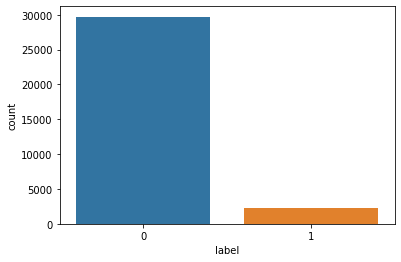

In [6]:
sns.countplot(x = train['label'])

In [7]:
train.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


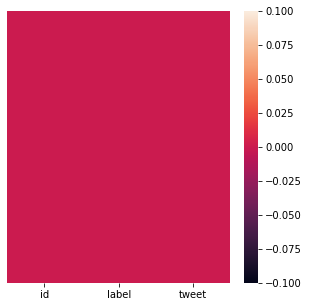

In [8]:
plt.figure(figsize=(5, 5))
sns.heatmap(train.isnull(), yticklabels=False) # Heatmap for visualising null values

## **Data pre-processing**
### Drop all other columns except “tweet” and “label”

In [9]:
trimmed_data = train.copy(deep=True)
for col in train.columns:
  if (col != 'tweet' and col != 'label'):
    trimmed_data.drop([col], axis=1, inplace=True)
trimmed_data.shape
trimmed_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [10]:
def top_words(df_tmp, num_top = 20):    
    words = []
    top_words_df = pd.Series([], dtype= 'object') # creating empty data series
        
    for row in df_tmp.iterrows(): # iterating through rows
        words.append(row[1][1].split())
        
    words = list(np.concatenate(words).flat) # list containg all words
    top_words_df = pd.DataFrame(words).value_counts().rename_axis('words')[:num_top].reset_index(name = 'count')
    return top_words_df

In [11]:
train_data_neutral = trimmed_data.loc[trimmed_data['label'] == 0]
train_data_hate_speech = trimmed_data.loc[trimmed_data['label'] == 1]

In [12]:
train_data_neutral.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


### Frequent words before pre-processing

In [13]:
neutral_train_top = top_words(train_data_neutral)
neutral_train_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,@user,15465
1,the,9249
2,to,9207
3,a,5654
4,i,5455
5,you,4555
6,and,4473
7,for,4196
8,in,4147
9,of,3695


In [14]:
hate_speech_train_top = top_words(train_data_hate_speech)
hate_speech_train_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,@user,1826
1,the,816
2,a,607
3,to,561
4,of,457
5,is,425
6,in,423
7,you,394
8,and,358
9,are,314


In [15]:
# Remove mentions (twitter handle names eg: @user) from the sentence
def remove_mentions(words):
    return " ".join(filter(lambda x:x[0]!='@', words.split()))

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_mentions(x))
trimmed_data.head()

,label,tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation


### Tokenization of tweets

In [16]:
Tokenizer=WhitespaceTokenizer()
trimmed_data['tweet'] = trimmed_data.apply(lambda row: Tokenizer.tokenize(row['tweet']), axis=1)
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, u, take, with, u, all, the, ..."
4,0,"[factsguide:, society, now, #motivation]"


### Replace contractions

In [17]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    new_words = []
    for word in text:
      new_word = contractions.fix(word)
      if new_word != '':
        new_words.append(new_word)
    return new_words

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: replace_contractions(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, cannot, use, b..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, you, take, with, you, all, t..."
4,0,"[factsguide:, society, now, #motivation]"


### Remove punctuations

In [18]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_punctuation(x))        

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Convert to lowercase

In [19]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: to_lowercase(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Stemming

In [20]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: lemmatize_list(x))    
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, be, dysfunctional, and, be, ..."
1,0,"[thank, for, lyft, credit, i, cannot, use, bec..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Remove stop words

In [21]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(words):
    new_words = []
    for word in words:
      if word not in stop_words:
          new_words.append(word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_stopwords(np.array(x)))    
trimmed_data.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drag, kid, dy..."
1,0,"[thank, lyft, credit, cannot, use, do not, off..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time, urð, ðððð, ððð]"
4,0,"[factsguide, society, motivation]"


### Normalize words

In [22]:
def normalize(words):   
    return ' '.join(words)
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: normalize(x))
trimmed_data.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cannot use do not offer whee...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [23]:
trimmed_data_neutral = trimmed_data.loc[trimmed_data['label'] == 0]
trimmed_data_hate_speech = trimmed_data.loc[trimmed_data['label'] == 1]

In [24]:
trimmed_data_neutral.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cannot use do not offer whee...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [25]:
trimmed_data_hate_speech.head()

,label,tweet
13,1,cnn call michigan middle school build wall cha...
14,1,comment australia opkillingbay seashepherd hel...
17,1,retweet agree
23,1,lumpy say prove lumpy
34,1,it is unbelievable 21st century we would need ...


### Frequent words after pre-processing

In [26]:
neutral_top = top_words(trimmed_data_neutral)
neutral_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,love,2892
1,ð,2465
2,day,2191
3,is,1771
4,get,1719
5,happy,1651
6,â,1595
7,i,1461
8,not,1446
9,go,1344


In [27]:
hate_speech_top = top_words(trimmed_data_hate_speech)
hate_speech_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,amp,268
1,trump,210
2,â,202
3,not,182
4,is,161
5,white,152
6,libtard,149
7,black,146
8,like,139
9,racist,102


### Vectorization (Convert text data to numbers).

In [28]:
data_for_countVectorizer = trimmed_data.copy(deep=True)

from sklearn.feature_extraction.text import CountVectorizer

ct_vectorizer = CountVectorizer(max_features=2000)                # Keep only 1000 features as number of features will increase the processing time.
cv_data_features = ct_vectorizer.fit_transform(data_for_countVectorizer['tweet'])
cv_data_features = cv_data_features.toarray()                        # Convert the data features to array.
print(cv_data_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [29]:
cv_data_features.shape

(31962, 2000)

In [30]:
labels = data_for_countVectorizer['label']
labels = labels.astype('int')
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64


### Split data into training and testing set.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(cv_data_features, labels, test_size=0.3, random_state=13)

### Random Forest Classifier for Count Vectorization

In [32]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

cv_forest = RandomForestClassifier(n_estimators=10, n_jobs=4, class_weight = "balanced")

cv_forest = cv_forest.fit(X_train, y_train)

print(cv_forest)

print(np.mean(cross_val_score(cv_forest, cv_data_features, labels, cv=10)))

RandomForestClassifier(class_weight='balanced', n_estimators=10, n_jobs=4)
0.9417743989495785


In [33]:
# Predict the result for test data using the model built above.
cv_result = cv_forest.predict(X_test)
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, cv_result)

print(conf_mat)

[[8656  298]
 [ 284  351]]


### Confusion Matrix for Count Vectorization Model

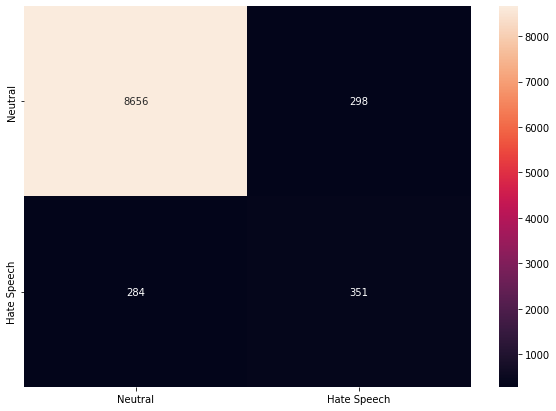

In [34]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [35]:
print('The accuracy score of the predicted model using CountVectorizer is: ', round(accuracy_score(y_test, cv_result),2)) 

The accuracy score of the predicted model using CountVectorizer is:  0.94


In [36]:
def plot_roc_curve(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

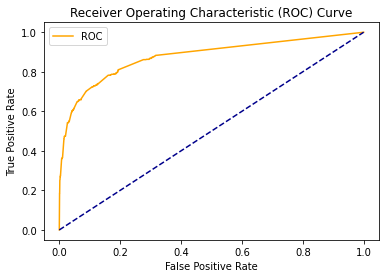

In [37]:
pred_prob1 = cv_forest.predict_proba(X_test)
pred_prob1 = pred_prob1[:, 1]  
fper, tper, thresholds = roc_curve(y_test, pred_prob1) 
plot_roc_curve(fper, tper)

In [38]:
print(classification_report(y_test, cv_result))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8954
           1       0.54      0.55      0.55       635

    accuracy                           0.94      9589
   macro avg       0.75      0.76      0.76      9589
weighted avg       0.94      0.94      0.94      9589



### Tf-Idf Vectorization

In [39]:
# TfidfVectorizer
data_for_TfidfVectorizer = trimmed_data.copy(deep=True)
# Using TfidfVectorizer to convert text data to numbers.

t_vectorizer = TfidfVectorizer(max_features=2000)
tv_data_features = t_vectorizer.fit_transform(data_for_TfidfVectorizer['tweet'])

tv_data_features = tv_data_features.toarray()

tv_data_features.shape

(31962, 2000)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(tv_data_features, labels, test_size=0.3, random_state=42)

In [41]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

tv_forest = RandomForestClassifier(n_estimators=10, n_jobs=4, class_weight = "balanced")
tv_forest = tv_forest.fit(X_train, y_train)
print(tv_forest)
print(np.mean(cross_val_score(tv_forest, tv_data_features, labels, cv=10)))

RandomForestClassifier(class_weight='balanced', n_estimators=10, n_jobs=4)
0.9533508710254412


### Confusion Matrix for TF-IDF vectorization Model

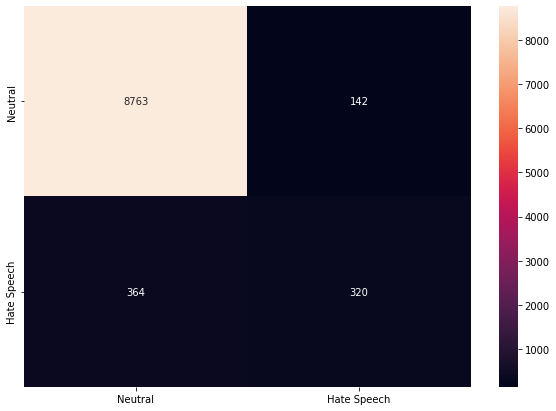

In [42]:
tv_result = tv_forest.predict(X_test)

conf_mat = confusion_matrix(y_test, tv_result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

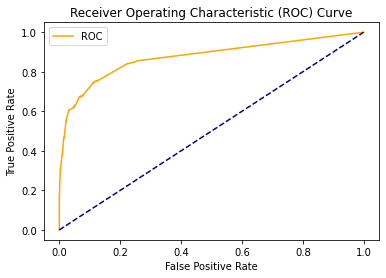

In [43]:
pred_prob2 = tv_forest.predict_proba(X_test)
pred_prob2 = pred_prob2[:, 1]  
fper, tper, thresholds = roc_curve(y_test, pred_prob2) 
plot_roc_curve(fper, tper)

In [44]:
print(classification_report(y_test, tv_result))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8905
           1       0.69      0.47      0.56       684

    accuracy                           0.95      9589
   macro avg       0.83      0.73      0.77      9589
weighted avg       0.94      0.95      0.94      9589



### Pipeline experimentation

In [70]:
from sklearn.pipeline import Pipeline

data_for_pipeline = trimmed_data.copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(data_for_pipeline, labels, test_size=0.3, random_state=42)
steps = [ ('tfidf', TfidfVectorizer()),
          ('randomforestclassifier', RandomForestClassifier())
      ]
pipe = Pipeline(steps)

pipe = pipe.fit(X_train['tweet'],y_train)
print(pipe)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])


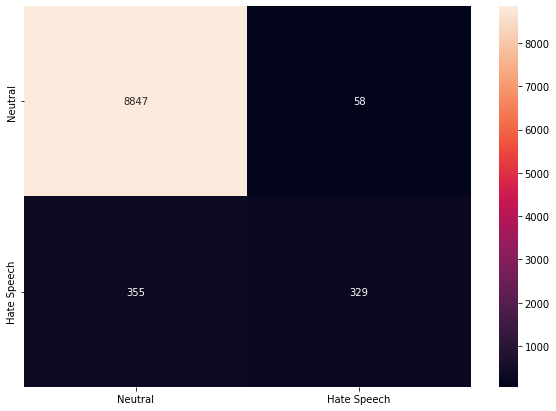

In [72]:
pipe_result = pipe.predict(X_test['tweet'])

conf_mat = confusion_matrix(y_test, pipe_result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [73]:
print(classification_report(y_test, pipe_result))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8905
           1       0.85      0.48      0.61       684

    accuracy                           0.96      9589
   macro avg       0.91      0.74      0.80      9589
weighted avg       0.95      0.96      0.95      9589

